In [1]:
import keras
from keras.models import Model
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils.class_weight import compute_class_weight
import random
from PIL import Image 


Using TensorFlow backend.


In [ ]:
with open ('df.p', 'rb') as f:
    df2 = pd.read_pickle(f)
f.close()
df2.replace('NA',np.nan,inplace=True)
df2['Index'] = list(df2.index)
df3 = df2.dropna(subset = ['price','sqft','bedrooms','bathrooms'])
#df3[['price','sqft','bedrooms','bathrooms']].apply(lambda x: float(x))
df3['price'].apply(lambda x: int(x))
df3['sqft'].apply(lambda x: int(x))
df3['bedrooms'].apply(lambda x: int(x))
df3['bathrooms'].apply(lambda x: int(x))


In [3]:
df3 = df3[df3['city']=='Oakland']

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


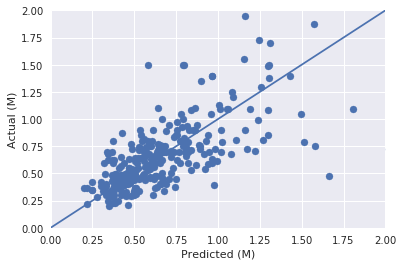

In [4]:
df3['zip'].apply(int)
X = df3[['sqft','bedrooms','bathrooms','zip']].values
#y = pd.DataFrame(df3['price'],index= df3.index).values
y = df3['price'].apply(int)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=300,random_state=7)


lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
y_pred = y_pred/10**6
y_test = y_test.values/10**6
plt.scatter(y_pred,y_test);
#plt.scatter(y_pred,df3['price'],c='r')
plt.plot(np.arange(0,3*10**7,1000),np.arange(0,3*10**7,1000));
#plt.xticks(0,2*10**6,500000)
plt.xlim(0,2);
plt.ylim(0,2);
plt.xlabel('Predicted (M)'),plt.ylabel('Actual (M)');


In [5]:
bedroom_dir = '/home/ubuntu/notebooks/web_scrape/beautiful_homes/bedroom/'
living_room_dir = '/home/ubuntu/notebooks/web_scrape/beautiful_homes/living-room/'
exterior_dir = '/home/ubuntu/notebooks/web_scrape/beautiful_homes/exterior/'
total_dir = '/home/ubuntu/notebooks/web_scrape/beautiful_homes/total/'
beautiful_bedroom = os.listdir(bedroom_dir)
beautiful_living_room = os.listdir(living_room_dir)
beautiful_exterior= os.listdir(exterior_dir)


In [ ]:
import shutil
random_list = list()

for file in beautiful_bedroom:
    n = random.randint(1,pow(10,5))
    
    while n in random_list:
        n = random.randint(1,pow(10,5))
    
    random_list.append(n)
    shutil.copy2(bedroom_dir+file,total_dir+str(n)+'.jpg')

for file in beautiful_living_room:
    n = random.randint(1,pow(10,5))
    
    while n in random_list:
        n = random.randint(1,pow(10,5))
    
    random_list.append(n)
    shutil.copy2(living_room_dir+file,total_dir+str(n)+'.jpg')


for file in beautiful_exterior:
    n = random.randint(1,pow(10,5))
    
    while n in random_list:
        n = random.randint(1,pow(10,5))
    
    random_list.append(n)
    shutil.copy2(exterior_dir+file,total_dir+str(n)+'.jpg')
    

In [6]:
# Setting up test-train splits
beautiful_total= os.listdir(total_dir)
train_beautiful_dir = '/home/ubuntu/notebooks/web_scrape/train/beautiful/'
test_beautiful_dir = '/home/ubuntu/notebooks/web_scrape/test/beautiful/'

In [ ]:
for index,file in enumerate(beautiful_total):
    if index < 0.7*len(beautiful_total):
        shutil.copy2(total_dir+file,train_beautiful_dir+file)
    if index >= 0.7*len(beautiful_total):
        shutil.copy2(total_dir+file,test_beautiful_dir+file)

In [7]:
ugly_total_dir = '/home/ubuntu/notebooks/web_scrape/uglyhouses/'
ugly_total= os.listdir(ugly_total_dir)
train_ugly_dir = '/home/ubuntu/notebooks/web_scrape/train/ugly/'
test_ugly_dir = '/home/ubuntu/notebooks/web_scrape/test/ugly/'

In [ ]:
for index,file in enumerate(ugly_total):
    if index < 0.7*len(ugly_total):
        shutil.copy2(ugly_total_dir+file,train_ugly_dir+file)
    if index >= 0.7*len(ugly_total):
        shutil.copy2(ugly_total_dir+file,test_ugly_dir+file)

In [8]:
# Making class weights
from collections import defaultdict
class_weights = defaultdict(float)

class_weights[0] = 1
class_weights[1] = len(beautiful_total)/(len(ugly_total))

#temp = min(class_weights.values())

#for i in class_weights.keys():
#    class_weights[i] = class_weights[i]/temp
class_weights


defaultdict(float, {0: 1, 1: 5.352095059412132})

In [9]:
# Setting up neural network

# dimensions of our images.
img_width, img_height = 224, 224
train_data_dir = '/home/ubuntu/notebooks/web_scrape/train/'
validation_data_dir = '/home/ubuntu/notebooks/web_scrape/test/'
#nb_train_samples = 1457
nb_train_samples = 14221

nb_validation_samples = 6091
epochs = 30
batch_size = 32

# build the VGG16 network
#model = applications.VGG16(weights='imagenet', include_top=False,input_shape=(3, 224,224) )
model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=None, classes=1000)

print('Model loaded.')

Model loaded.


In [10]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers:
    layer.trainable = False


last = model.output
x = Flatten()(last)
x = Dense(256,activation='relu')(x)
x = Dropout(0.5)(x)

preds = Dense(3, activation='softmax')(x)

model = Model(model.input, preds)
#model.compile(loss='categorical_crossentropy',
#              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#              metrics=['accuracy'])




In [11]:
model.load_weights('vgg16_room_classification.h5')

In [12]:
#print(model
model.layers.pop()

In [13]:
for layer in model.layers:
    layer.trainable = False
    
preds = Dense(2, activation='softmax')(model.layers[-1].output)
model = Model(model.input, preds)


In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['binary_accuracy'])


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
        rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [16]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    #class_mode = None
    
   )

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,

    #class_mode = None

    )

Found 14221 images belonging to 2 classes.
Found 6091 images belonging to 2 classes.


In [17]:
model.load_weights('vgg16_beautiful_ugly3.h5')
model.layers.pop()
model.layers.pop()
for layer in model.layers:
    layer.trainable = False

preds = Dense(2, activation='softmax')(model.layers[-1].output)
model = Model(model.input, preds)
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['binary_accuracy'])

In [19]:
model.load_weights('vgg16_beautiful_ugly_test4.h5')

In [ ]:
checkpoint = ModelCheckpoint("vgg16_beautiful_ugly_test4.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=1, verbose=0, mode='auto')
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,  
          write_graph=True, write_images=True)

# fine-tune the model
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples/batch_size,
    callbacks = [checkpoint,tbCallBack],
    class_weight=class_weights
    #callbacks = [checkpoint]
)

In [ ]:
# obtaining probabilities of prediction

#root_dir = total_dir
root_dir = ugly_total_dir

dir_list = os.listdir(root_dir)
#prediction_dict = defaultdict(list)
prediction_list = list()
price = [0,1]
n = 0


for file in dir_list:
    
    im = Image.open(root_dir+file)
    im = im.resize((img_height, img_width))
    images = np.array([np.asarray(im)])/255
    pred_proba = model.predict(images,batch_size=1)
    
    
    
    #np.dot(pred_proba,price)
    prediction_list.append(pred_proba[0])
#    prediction_dict[int(file.split('_')[0])].append(np.dot(pred_proba,price))
    
    
    if n>1700: break
    n += 1
    if n%100 ==0:
        print(n)

# Taking average of predictions

In [23]:
#beautiful_list = prediction_list
ugly_list = prediction_list

In [ ]:
# obtaining probabilities of prediction

root_dir = total_dir
dir_list = os.listdir(root_dir)
#prediction_dict = defaultdict(list)
prediction_list = list()
price = [0,1]
n = 0


for file in dir_list:
    
    im = Image.open(root_dir+file)
    im = im.resize((img_height, img_width))
    images = np.array([np.asarray(im)])/255
    pred_proba = model.predict(images,batch_size=1)
    
    
    
    #np.dot(pred_proba,price)
    prediction_list.append(pred_proba[0])
#    prediction_dict[int(file.split('_')[0])].append(np.dot(pred_proba,price))
    
    if n> 155: break
    
    if n>1700: break
    n += 1
    if n%100 ==0:
        print(n)

# Taking average of predictions

In [25]:
beautiful_list = prediction_list


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


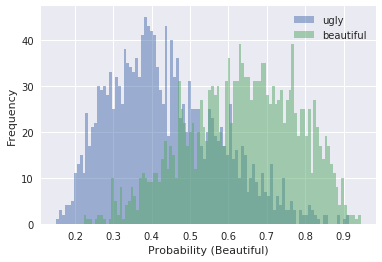

In [23]:
ax1,*_ = plt.hist([x[0] for x in ugly_list],bins=100,alpha = 0.5,label='ugly');
ax2,*_ = plt.hist([x[0] for x in beautiful_list],bins=100,alpha = 0.5,label='beautiful');
#plt.legend(handles = ['Ugly','Beautiful'])
#plt.legend('u' 'b')
plt.legend(loc='upper right');
plt.xlabel('Probability (Beautiful)');
plt.ylabel('Frequency');

In [21]:
df4 = df3[df3['city']=='Oakland']


In [209]:
oakland_dir = os.listdir('/home/ubuntu/notebooks/oakland/pics')
temp = [int(x.split('_')[0]) for x in oakland_dir]
beautiful_prob_dict = defaultdict(list)

for n in range(min(df4.index),max(df4.index)+1):
    temp2 = list()
    for file in oakland_dir:
        if int(file.split('_')[0]) == n:
            im = Image.open('/home/ubuntu/notebooks/oakland/pics/'+file)
            im = im.resize((img_height, img_width))
            images = np.array([np.asarray(im)])/255
            #model2.predict(images,batch_size=1)
            
            beautiful_prob_dict[n].append(model.predict(images,batch_size=1)[0][0])
    


In [210]:
#beautiful_prob_dict = backup

In [211]:
for i in beautiful_prob_dict.keys():
    beautiful_prob_dict[i] = np.mean(beautiful_prob_dict[i])

for n in range(min(df4.index),max(df4.index)+1):
    if n not in beautiful_prob_dict.keys():
        beautiful_prob_dict[n] = np.nan

In [212]:

pic_prob_df = pd.DataFrame.from_dict(beautiful_prob_dict,orient='index')
pic_prob_df.columns = ['prob']


In [ ]:

df_total = pd.merge(df4,pic_prob_df,left_index = True, right_index = True)
df_total['price'] = [int(x) for x in df_total['price'].values]
df_total['sqft'].apply(lambda x: int(x))
df_total['bedrooms'].apply(lambda x: int(x))
df_total['bathrooms'].apply(lambda x: int(x))


In [214]:
# Dropping NA and greater than 2M
df_total.dropna(subset=['prob'],inplace=True)
#df_total.head()
df_total = df_total[df_total['price'] < 2000000]

24736058767.2
0.630105358288


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


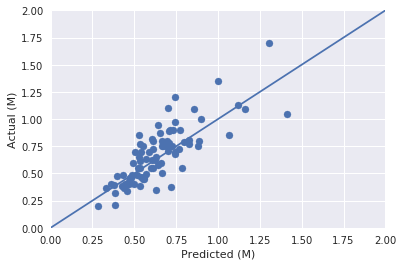

In [320]:
# With photos

X = df_total[['sqft','bedrooms','bathrooms','zip','prob']].values
#y = pd.DataFrame(df3['price'],index= df3.index).values
y = df_total['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=7)


gbr = GradientBoostingRegressor(learning_rate = 0.121,n_estimators=100, random_state = 7)
gbr.fit(X_train,y_train)
y_pred_gbr = gbr.predict(X_test)

print(mean_squared_error(y_test,y_pred_gbr))
print(r2_score(y_test,y_pred_gbr))


#plt.scatter(y_pred_gbr,y_test)
#plt.plot(np.arange(100,pow(10,6),100),np.arange(100,pow(10,6),100))

plt.scatter(y_pred_gbr/pow(10,6),y_test/pow(10,6));
#plt.scatter(y_pred,df3['price'],c='r')
plt.plot(np.arange(0,3*10**7,1000)/pow(10,6),np.arange(0,3*10**7,1000)/pow(10,6));
#plt.xticks(0,2*10**6,500000)
plt.xlim(0,2);
plt.ylim(0,2);
plt.xlabel('Predicted (M)'),plt.ylabel('Actual (M)');


In [307]:
gbr.feature_importances_

array([ 0.37653054,  0.06877445,  0.06041036,  0.19703456,  0.29725009])

29834016210.1
0.553872229981


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


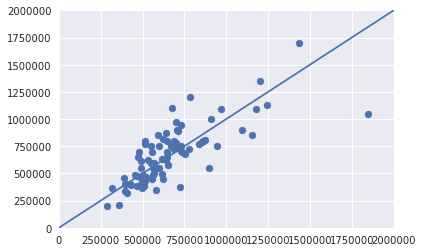

In [297]:
# Without photos

X = df_total[['sqft','bedrooms','bathrooms','zip']].values
#y = pd.DataFrame(df3['price'],index= df3.index).values
y = df_total['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=7)


gbr = GradientBoostingRegressor(learning_rate=0.13,random_state = 7)
gbr.fit(X_train,y_train)
y_pred_gbr = gbr.predict(X_test)



print(mean_squared_error(y_test,y_pred_gbr))
print(r2_score(y_test,y_pred_gbr))
#plt.scatter(y_pred_gbr,y_test)
#plt.plot(np.arange(100,pow(10,6),100),np.arange(100,pow(10,6),100))

plt.scatter(y_pred_gbr,y_test);
#plt.scatter(y_pred,df3['price'],c='r')
plt.plot(np.arange(0,3*10**7,1000),np.arange(0,3*10**7,1000));
plt.xlim(0,2*10**6);
plt.ylim(0,2*10**6);




In [218]:
gbr.feature_importances_


array([ 0.51058485,  0.1393392 ,  0.07411811,  0.27595784])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


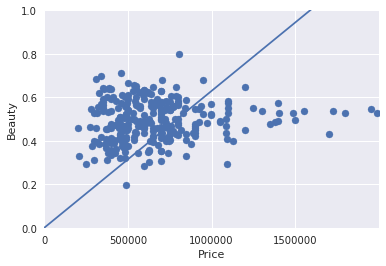

In [219]:
# Plotting the Probability of Beautiful as sa function of price

lr_prob = LinearRegression(fit_intercept=False)
lr_prob.fit(pd.DataFrame(df_total['price']),df_total['prob'].values)
plt.plot(np.arange(0,3000000,500000),np.arange(0,3000000,500000)*lr_prob.coef_)

plt.scatter(df_total['price'],df_total['prob'])
plt.xlim(0,2000000)
plt.ylim(0,1)

plt.xticks(np.arange(0,2000000,500000))
plt.xlabel('Price')
plt.ylabel('Beauty')



In [220]:
lr_prob.coef_

array([  6.29684945e-07])

In [22]:
## putting in the vectors of the output of the neural network
model.layers.pop()
model.layers.pop()
preds = Dense(256, activation='softmax')(model.layers[-1].output)
model = Model(model.input, preds)
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [61]:
oakland_dir = os.listdir('/home/ubuntu/notebooks/oakland/pics')
temp = [int(x.split('_')[0]) for x in oakland_dir]
beautiful_prob_dict = defaultdict(list)

for n in range(min(df4.index),max(df4.index)+1):
    temp2 = list()
    for file in oakland_dir:
        if int(file.split('_')[0]) == n:
            im = Image.open('/home/ubuntu/notebooks/oakland/pics/'+file)
            im = im.resize((img_height, img_width))
            images = np.array([np.asarray(im)])/255
            #model2.predict(images,batch_size=1)
            
            beautiful_prob_dict[n].append(model.predict(images,batch_size=1))
    
